In [27]:
# Import stuff
import os
import scipy
from tqdm import tqdm, trange
from joblib import Parallel,delayed
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt

%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(11, 9)

os.chdir('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [2]:
data_dir = '/media/bigdata/Abuzar_Data/AS18/AS18_4Tastes_200229_154608'
dat = \
    ephys_data(data_dir)
dat.firing_rate_params = dict(zip(\
    ('type', 'step_size','window_size','dt', 'baks_resolution', 'baks_dt'),
    ('conv',1,250,1,1e-3,1e-3)))

dat.get_unit_descriptors()
dat.get_spikes()
dat.get_firing_rates()

All tastes have equal dimensions,concatenating and normalizing


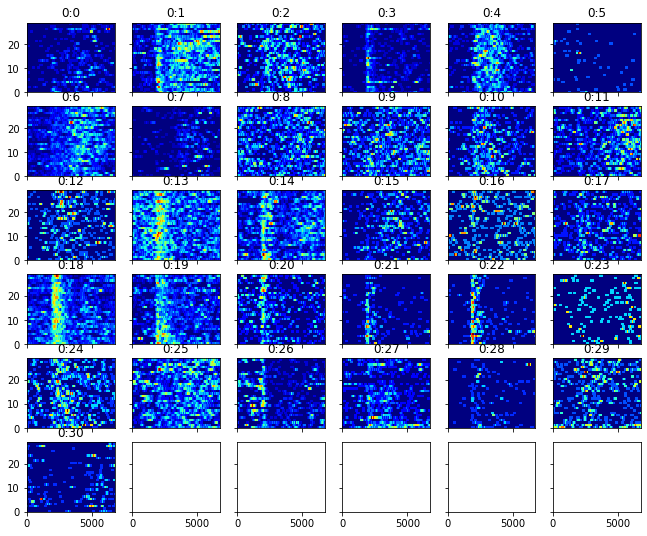

In [3]:
# Use MCMC changepoint separately on trials for single neuron
taste = 0
visualize.firing_overview(dat.firing_array[taste]);plt.show()

In [4]:
nrn = 6
this_dat = dat.spikes[taste][:,nrn]
print(this_dat.shape)

(30, 7000)


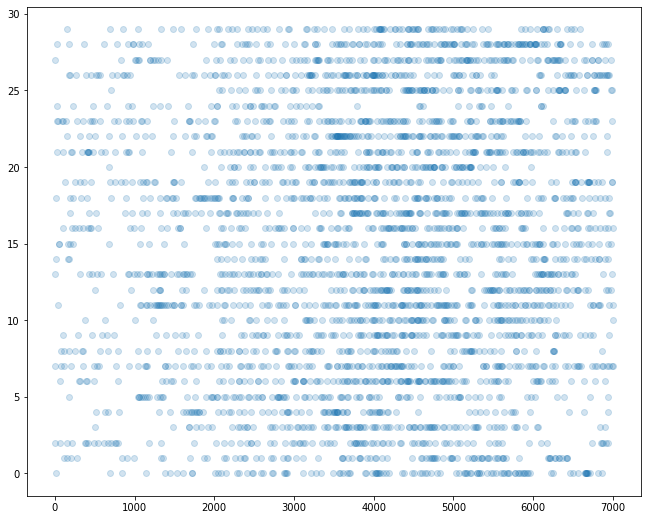

In [5]:
spike_inds = np.where(this_dat)
plt.scatter(spike_inds[1],spike_inds[0],alpha = 0.2)

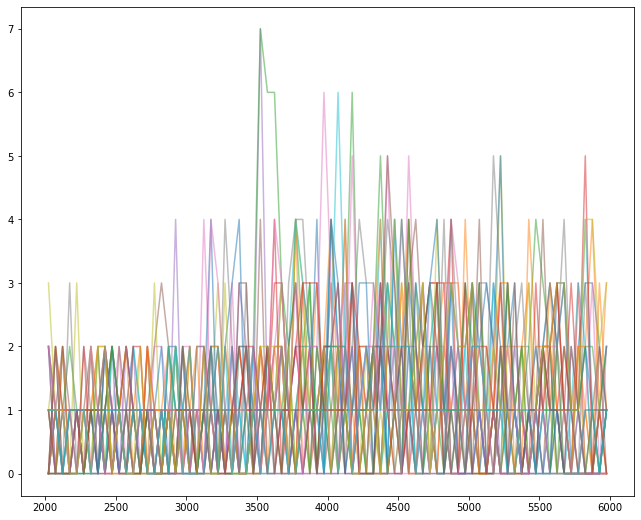

In [6]:
# Convert spikes to counts by binning
time_lims = [2000,6000]
bin_width = 50
t_vec = np.arange(this_dat.shape[-1])
binned_t_vec = np.mean(t_vec[time_lims[0]:time_lims[1]].reshape((-1,bin_width)),axis=-1)
this_dat_binned = np.sum(this_dat[...,time_lims[0]:time_lims[1]].reshape(this_dat.shape[0],-1,bin_width),axis=-1)
this_dat_binned = np.vectorize(np.int)(this_dat_binned)
plt.plot(binned_t_vec,this_dat_binned.T,alpha =0.5);plt.show()

[23 24 21 18 22 17 26 24 27 24 21 19 23 19 20 18 18 23 24 25 23 16 27 31
 22 25 25 28 29 24 39 36 42 42 25 44 40 38 35 37 50 41 41 40 31 32 34 45
 43 44 36 50 32 36 36 45 30 42 27 33 37 33 21 35 40 30 26 22 26 28 40 35
 39 31 17 24 34 24 21 28]
Average count = 30.2875


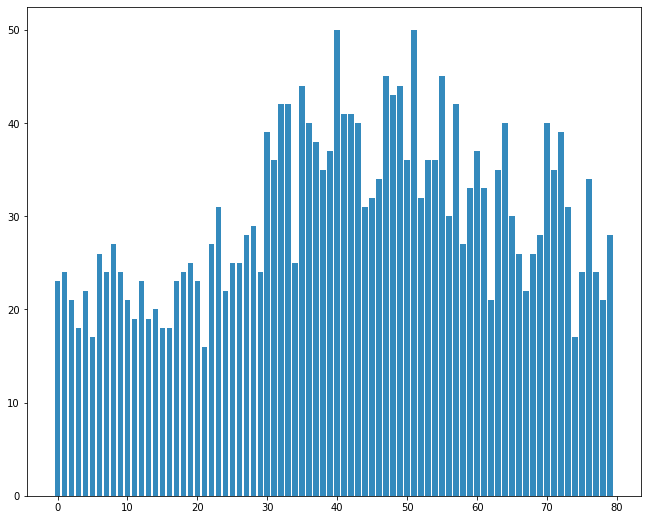

In [7]:
#trial = 0
#count_data = this_dat_binned[trial]
count_data = np.sum(this_dat_binned,axis=0)
n_count_data = len(count_data)
print(count_data)
print('Average count = {}'.format(count_data.mean()))
plt.bar(np.arange(n_count_data),count_data,color="#348ABD");plt.show()


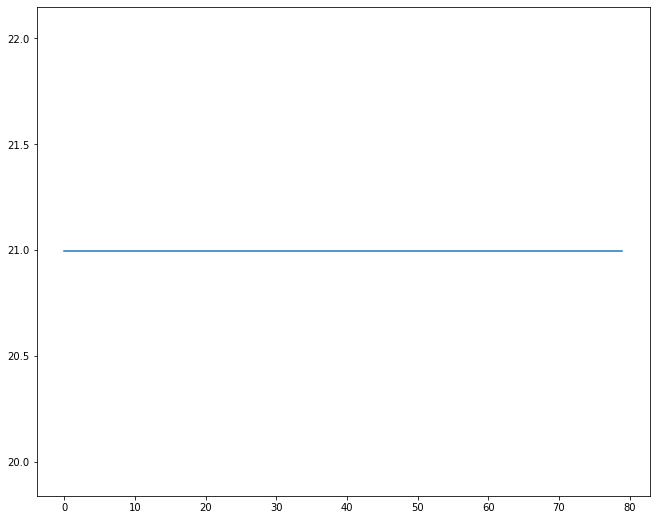

In [12]:
with pm.Model() as model:
    # Defining variables with priors
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    #tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
    
with model:
    idx = np.arange(n_count_data) # Index
    
    # Scaled beta mixture "somewhere in the middle" prior
    #a = pm.HalfNormal('a_hp', 3.)
    #b = pm.HalfNormal('b_hp', 3.)
    a = 3
    b = 3
    tau_latent = pm.Beta('tau_latent', a, b)
    tau = pm.Deterministic('tau', idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    # Using sigmoid rather than switch is supposed to be better
    # for sampler
    
    weight = tt.nnet.sigmoid(2 * (idx - tau))
    lambda_ = weight * lambda_1 + (1 - weight) * lambda_2  
    
    #lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    

    
plt.plot(lambda_.tag.test_value);

In [13]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=count_data)

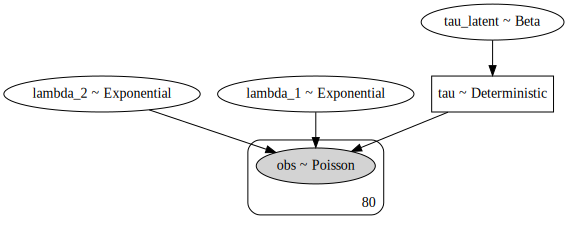

In [14]:
pm.model_to_graphviz(model)

In [15]:
with model:
    #step = pm.Metropolis()
    #trace = pm.sample(15000, tune=5000,step=step)
    trace = pm.sample(15000, tune=5000, chains = 8, cores = 8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_latent, lambda_2, lambda_1]
Sampling 8 chains, 0 divergences: 100%|██████████| 160000/160000 [00:33<00:00, 4799.34draws/s]
The acceptance probability does not match the target. It is 0.7136974290190197, but should be close to 0.8. Try to increase the number of tuning steps.


In [16]:
pm.summary(trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda_1,34.56,0.85,32.98,36.19,0.00,0.0,69451.0,69309.0,69518.0,70558.0,1.0
lambda_2,22.50,0.95,20.75,24.32,0.00,0.0,73275.0,73275.0,73228.0,76742.0,1.0
tau_latent,0.35,0.02,0.32,0.38,0.00,0.0,50381.0,50381.0,58867.0,47459.0,1.0
tau,27.85,1.44,25.29,30.23,0.01,0.0,50381.0,50381.0,58867.0,47459.0,1.0


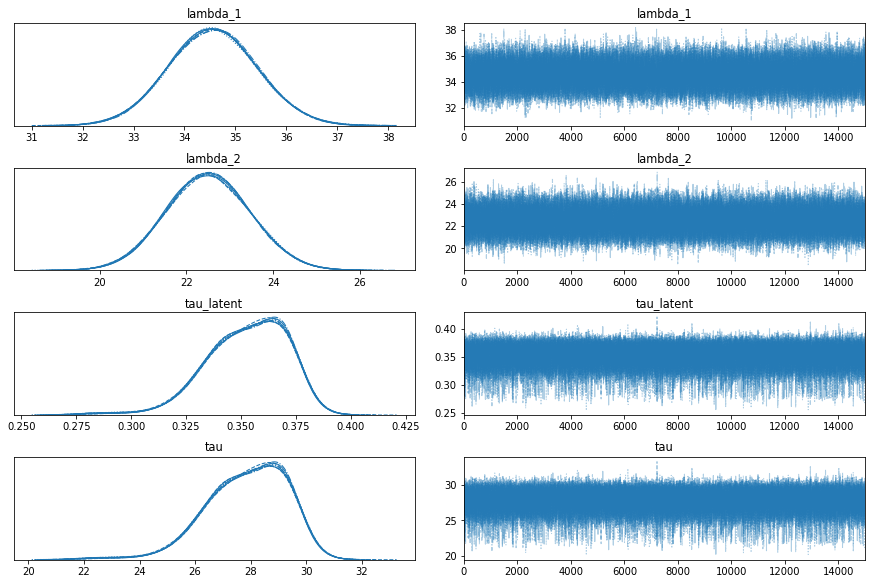

In [18]:
pm.traceplot(trace);

In [19]:
ppc = pm.sample_posterior_predictive(trace, samples = 10000, model = model)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 10000/10000 [00:07<00:00, 1419.77it/s]


In [20]:
ppc['obs'].shape

(10000, 80)

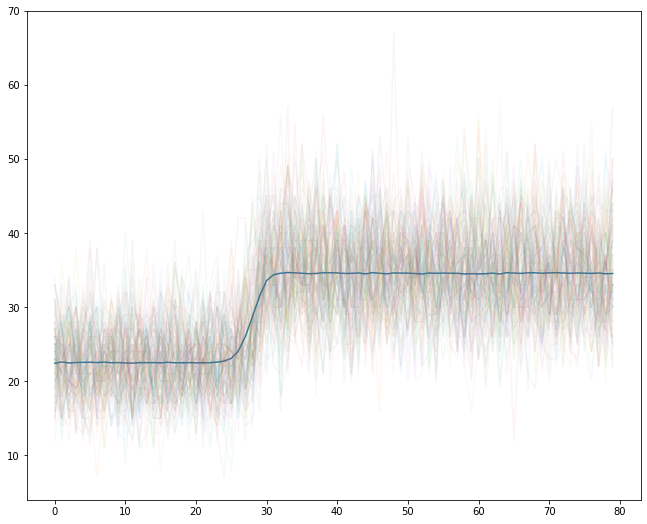

In [21]:
plt.plot(np.mean(ppc['obs'],axis=0));
traces = 100
plt.plot(ppc['obs'][:100].T, alpha = 0.05);

In [23]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

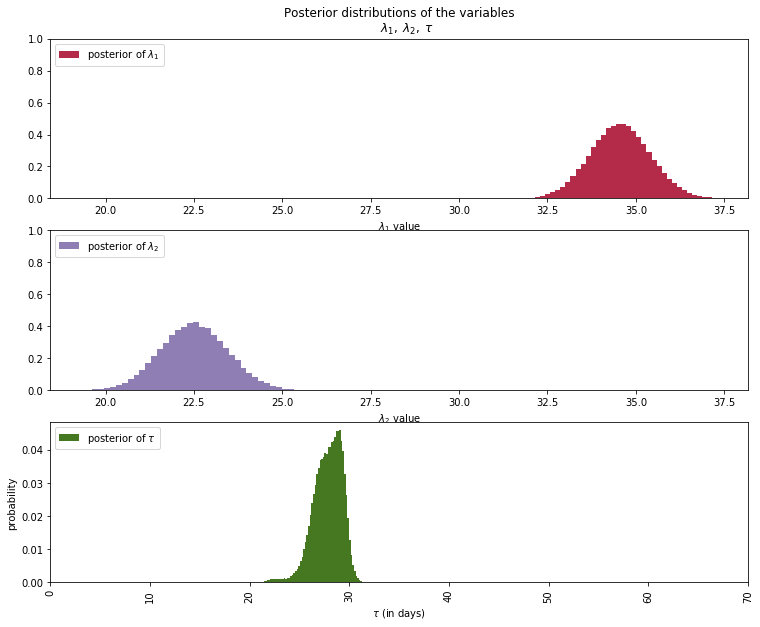

In [24]:
figsize(12.5, 10)
#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)
collected_samples = [*lambda_1_samples,*lambda_2_samples]
x_lims = [min(collected_samples),max(collected_samples)]

plt.hist(lambda_1_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlabel("$\lambda_1$ value")
plt.xlim(x_lims)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=50, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlabel("$\lambda_2$ value")
plt.xlim(x_lims)


plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data,step=10))


plt.legend(loc="upper left")
plt.xlabel(r"$\tau$ (in days)")
plt.xticks(rotation='vertical')
plt.ylabel("probability");

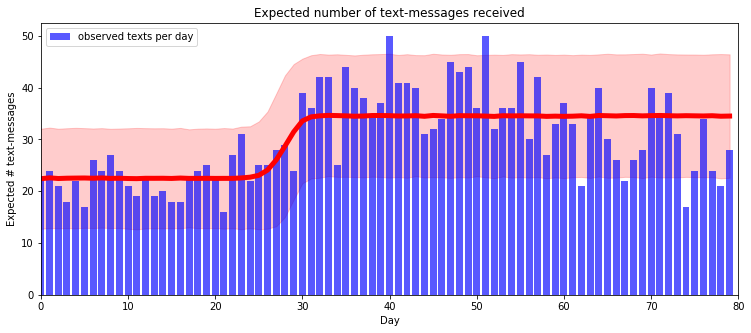

In [25]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
#N = tau_samples.shape[0]
#expected_texts_per_day = np.zeros(n_count_data)
#for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    
    #ix = day > tau_samples
    
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    #expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
    #                               + lambda_2_samples[~ix].sum()) / N

# Plot Mean trace with SD
mean_val = np.mean(ppc['obs'],axis=0)
std_val = np.std(ppc['obs'],axis=0)
plt.fill_between(x = np.arange(len(mean_val)),
                    y1 = mean_val - 2*std_val,
                    y2 = mean_val + 2*std_val,
                alpha = 0.2, color = 'red');
plt.plot(np.arange(len(mean_val)), mean_val, color = 'red', linewidth=5)

#plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
#         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.bar(np.arange(len(count_data)), count_data, color="blue", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");